In [2]:
from ca_lecture_hall_model import Grid, generate_gif

In [3]:
# Generate a grid for given size, density and spread threshold
size = 20
density = 0.7
spread_threshold = 0.3

g = Grid(size, density, spread_threshold)

In [4]:
# Initialize the board and set the initial spreader
g.initialize_board()
g.show_grid()

GIF saved to: /Users/hazel/CSS_EscapePanic/images/spread_simulation.gif
All frames saved to: /Users/hazel/CSS_EscapePanic/images


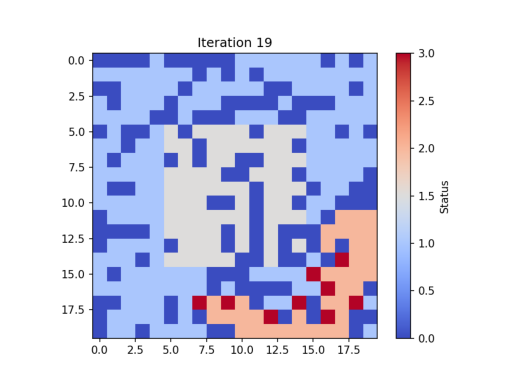

In [5]:
generate_gif(g, steps=20, gif_name="spread_simulation.gif")